In [2]:
import cv2
import easyocr
import imutils
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import mysql.connector

In [3]:
#connect to myapp_db
def connect_db():
  mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    database="bulding_db"
  )
  return mydb

In [31]:
def date_time():
          real_time = datetime.now() # current date and time
          time = real_time.strftime("%H:%M:%S")
          date = real_time .strftime("%m/%d/%Y")
          return date,time

In [24]:
#export last id from cars table
def get_last_id_from_db():
    id=[]
    try:
            connection=connect_db()
            sql_select_Query = "SELECT id from `cars`"
            cursor = connection.cursor()
            cursor.execute(sql_select_Query)
            # get all records
            record_id = cursor.fetchall()
            id.append(record_id[-1][-1])                  
            return id
                
    except mysql.connector.Error as error:
        print("Failed selecting last data into MySQL table {}".format(error))

In [25]:
get_last_id_from_db()

[2]

In [18]:
#insert into db: table cars
def insert_db_cars(car_liencense):
    id=get_last_id_from_db()[0]+1
    print("Inserting into cars table")
    try:
        connection = connect_db()
        cursor = connection.cursor()
        sql_insert_blob_query = """ INSERT INTO `cars`(`id`, `liecense_palet`) 
                                     VALUES (%s,%s)"""

        # Convert data into tuple format
        insert_blob_tuple = (id,car_liencense)
        result = cursor.execute(sql_insert_blob_query, insert_blob_tuple)
        connection.commit()
        print("Datas successfully into cars table", result)

    except mysql.connector.Error as error:
        print("Failed inserting data into MySQL table {}".format(error))

    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

In [27]:
insert_db_cars("45غ789")


Inserting into cars table
Datas successfully into cars table None
MySQL connection is closed


In [36]:
#insert into db: table cars
def insert_db_cars(id):
    print("Inserting into log table")
    date=date_time()[0]
    time=date_time()[1]
    try:
        connection = connect_db()
        cursor = connection.cursor()
        sql_insert_blob_query = """ INSERT INTO `input_output`(`id`, `date`,`time`) 
                                     VALUES (%s,%s,%s)"""

        # Convert data into tuple format
        insert_blob_tuple = (id,date,time)
        result = cursor.execute(sql_insert_blob_query, insert_blob_tuple)
        connection.commit()
        print("Datas successfully into input_output table", result)

    except mysql.connector.Error as error:
        print("Failed inserting data into MySQL table {}".format(error))

    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

In [37]:
insert_db_cars(1)

Inserting into log table
Datas successfully into input_output table None
MySQL connection is closed


In [10]:
#export cars from db
def get_data_from_db():
    images=[]
    data=[]
    try:
            connection=connect_db()
            sql_select_Query = "select * FROM `cars`"
            cursor = connection.cursor()
            cursor.execute(sql_select_Query)
            # get all records
            records = cursor.fetchall()
                
            return records
                
    except mysql.connector.Error as error:
        print("Failed selecting BLOB data into MySQL table {}".format(error))

In [38]:
get_data_from_db()

[(1, '11ب234'), (2, '13ل123'), (2, '12ا567'), (3, '23ا368'), (4, '45غ789')]

date: 08/27/2023
time: 01:46:09


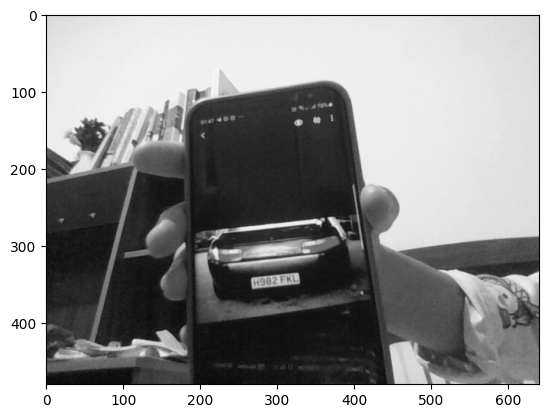

In [90]:
#Read image from video camera , gray scale and blur
# img = cv2.imread('./images/image1.jpg')
cap=cv2.VideoCapture(0)
_,img=cap.read()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
cap.release()
cv2.destroyAllWindows()
date_time()

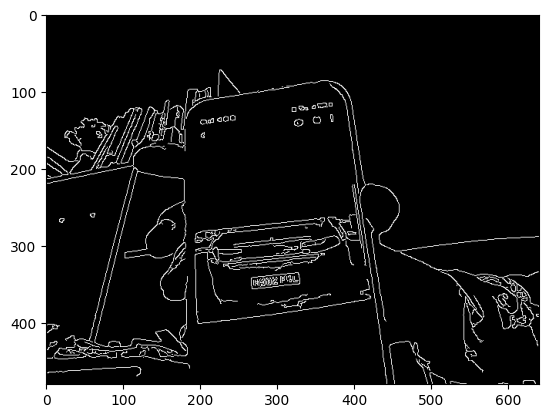

In [91]:
#apply filter and find edges for localization
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [92]:
#find contours and apply mask
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [93]:
location_numberPlate = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location_numberPlate = approx
        break

In [94]:
location_numberPlate

array([[[328, 337]],

       [[268, 341]],

       [[267, 356]],

       [[328, 350]]], dtype=int32)

In [95]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location_numberPlate], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

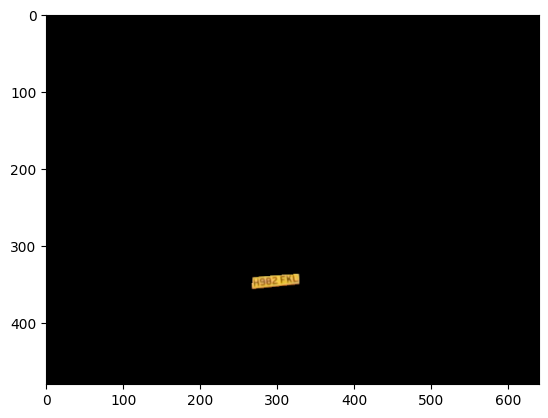

In [96]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [97]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

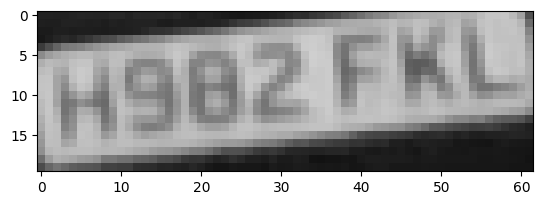

In [98]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [2]:
import pygame
import random
import time

pygame.init()

# تعیین رنگ‌ها
black = (0, 0, 0)
white = (255, 255, 255)
red = (213, 50, 80)
green = (0, 255, 0)

# تنظیمات اولیه
dis_width = 800
dis_height = 600
dis = pygame.display.set_mode((dis_width, dis_height))
pygame.display.set_caption('Snake Game')

snake_block = 10
snake_speed = 10

font_style = pygame.font.SysFont(None, 50)
score_font = pygame.font.SysFont(None, 35)

def our_snake(snake_block, snake_list):
    for x in snake_list:
        pygame.draw.rect(dis, green, [x[0], x[1], snake_block, snake_block])

def message(msg, color):
    mesg = font_style.render(msg, True, color)
    dis.blit(mesg, [dis_width / 6, dis_height / 3])

clock = pygame.time.Clock()

def gameLoop():
    game_over = False
    game_close = False

    x1 = dis_width / 2
    y1 = dis_height / 2

    x1_change = 0
    y1_change = 0

    snake_List = []
    Length_of_snake = 1

    foodx = round(random.randrange(0, dis_width - snake_block) / 10.0) * 10.0
    foody = round(random.randrange(0, dis_height - snake_block) / 10.0) * 10.0

    while not game_over:

        while game_close == True:
            dis.fill(black)
            message("You Lost! Press C-Play Again or Q-Quit", red)
            pygame.display.update()

            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_q:
                        game_over = True
                        game_close = False
                    if event.key == pygame.K_c:
                        gameLoop()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                game_over = True
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT:
                    x1_change = -snake_block
                    y1_change = 0
                elif event.key == pygame.K_RIGHT:
                    x1_change = snake_block
                    y1_change = 0
                elif event.key == pygame.K_UP:
                    y1_change = -snake_block
                    x1_change = 0
                elif event.key == pygame.K_DOWN:
                    y1_change = snake_block
                    x1_change = 0

        if x1 >= dis_width or x1 < 0 or y1 >= dis_height or y1 < 0:
            game_close = True
        x1 += x1_change
        y1 += y1_change
        dis.fill(black)
        pygame.draw.rect(dis, red, [foodx, foody, snake_block, snake_block])
        snake_Head = []
        snake_Head.append(x1)
        snake_Head.append(y1)
        snake_List.append(snake_Head)
        if len(snake_List) > Length_of_snake:
            del snake_List[0]

        for x in snake_List[:-1]:
            if x == snake_Head:
                game_close = True

        our_snake(snake_block, snake_List)

        pygame.display.update()

        if x1 == foodx and y1 == foody:
            foodx = round(random.randrange(0, dis_width - snake_block) / 10.0) * 10.0
            foody = round(random.randrange(0, dis_height - snake_block) / 10.0) * 10.0
            Length_of_snake += 1

        clock.tick(snake_speed)

    pygame.quit()
    quit()

gameLoop()


: 